# Rare Cell Coverage (cell type)

In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
import pickle

# Get the file path from environment variable
file_path_env = '/fast/AG_Ohler/ekarimi/projects/FACS_Sampling/data'
OBS_FEATURES = ['prediction','organ','sample_group','label','group','celltype','sample_id']
DROP_FEATURES = ['SSC-B-H','SSC-B-A']

REFERENCES = [1, 5, 10, 20, 34]
references = [1, 5, 10, 20]
METHODS = ['random', 'cubic', 'hopper', 'atomic']
methods = ['random', 'cubic', 'hopper']
SIZES = [50000, 100000, 200000]
REPS = [i for i in range(5)]
label_key = 'celltype'


directory = "lcmv/benchmark"
PATH = os.path.join(file_path_env, directory)

In [2]:
ref = 1
method = 'cubic'
size = 100000
rep = 0
# REFERENCES = [1, 5]
# methods = ['random', 'cubic', 'atomic', 'hopper']


In [3]:
reference_adatas = {}
for ref in REFERENCES:
    address = os.path.join(PATH, f"{ref}/adata.h5ad")
    adata = sc.read_h5ad(address)
    adata.obs[label_key] = adata.obs[label_key].astype('category')
    adata.var.index = adata.var.index.astype('object')
    reference_adatas[ref] = adata

In [4]:

def prepare_cell_type_coverage():
    res_size = {}
    new_lable_orders_size = {}
    for size in SIZES:

        res = {}
        new_label_orders = {}

        for ref in REFERENCES:
            adata = reference_adatas[ref]

            real_counts = adata.obs[label_key].value_counts()
            rare_dict = real_counts < adata.shape[0]/100
            rare_types = [x for x in rare_dict.keys() if rare_dict[x]==True]
            adata.obs['rare'] = adata.obs.apply(lambda x: True if x[label_key] in rare_types else False , axis=1)

            label_order = adata.obs[label_key].value_counts().keys().values

            group_dict = {
                label_key:[],
                'count':[],
                'method':[]
                         }

            for rep in REPS:
                for method in METHODS:
                    if method == 'atomic':
                        if os.path.isfile(os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")):
                            
                            atomic_address = os.path.join(PATH, f"{ref}/atomic/{size}/{rep}/results.csv")
                            indices = pd.read_csv(atomic_address)['x'].values.astype(str)
                        else:
                            continue
                    else:
                        samples_address = os.path.join(PATH, f"{ref}/{method}/{size}/{rep}/results.pkl")
                        with open(samples_address, 'rb') as handle:
                             samples= pickle.load(handle)
                        indices = samples[0]

                    counts = adata[indices].obs[label_key].value_counts().tolist()
                    labels = adata[indices].obs[label_key].value_counts().keys().tolist()
                    method_rep = [method for _ in counts]

                    group_dict[label_key].extend(labels)
                    group_dict['count'].extend(counts)
                    group_dict['method'].extend(method_rep)

            gdf = pd.DataFrame.from_dict(group_dict)
            cc = adata.obs[label_key].value_counts()
            gdf['coverage_percent'] = gdf.apply(lambda x: (x['count'] / cc[x[label_key]]) * 100, axis=1)

            res[ref] = gdf[gdf[label_key].isin(rare_types)]

            new_label_order = []
            for i in range(len(label_order)):
                if label_order[i] in rare_types:
                    new_label_order.append(label_order[i])
            new_label_orders[ref] = new_label_order

        res_size[size] = res
        new_lable_orders_size[size] = new_label_orders
        
    return res_size ,new_lable_orders_size

In [ ]:
res_size ,new_lable_orders_size = prepare_cell_type_coverage()

In [28]:
import pickle

def save_data_pickle(data, file_name):
    with open(file_name, 'wb') as f:
        pickle.dump(data, f)

def load_data_pickle(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

# # Save the data
save_data_pickle(res_size, 'results_data/2_res_size.pkl')
save_data_pickle(new_lable_orders_size, 'results_data/2_new_lable_orders_size.pkl')

# # Load the data
# loaded_data = load_data_pickle('results_data/2_data.pkl')
# print(loaded_data)



### size=50000

In [7]:
size = 50000
res = res_size[size]
new_label_orders = new_lable_orders_size[size]

,celltype,count,method,coverage_percent
11,CD4_LCMV_spec,452,random,4.786614
12,Plasma_cells,377,random,5.308364
13,pDC_like,322,random,5.253712
14,pDCs,291,random,5.199214
15,CD138_pos_PC_like,274,random,5.558937
...,...,...,...,...
415,TCRgd_T,447,atomic,10.602467
416,CD138_pos_PC_like,360,atomic,7.303713
417,Eosino,347,atomic,13.465270
418,interacting,146,atomic,21.251820


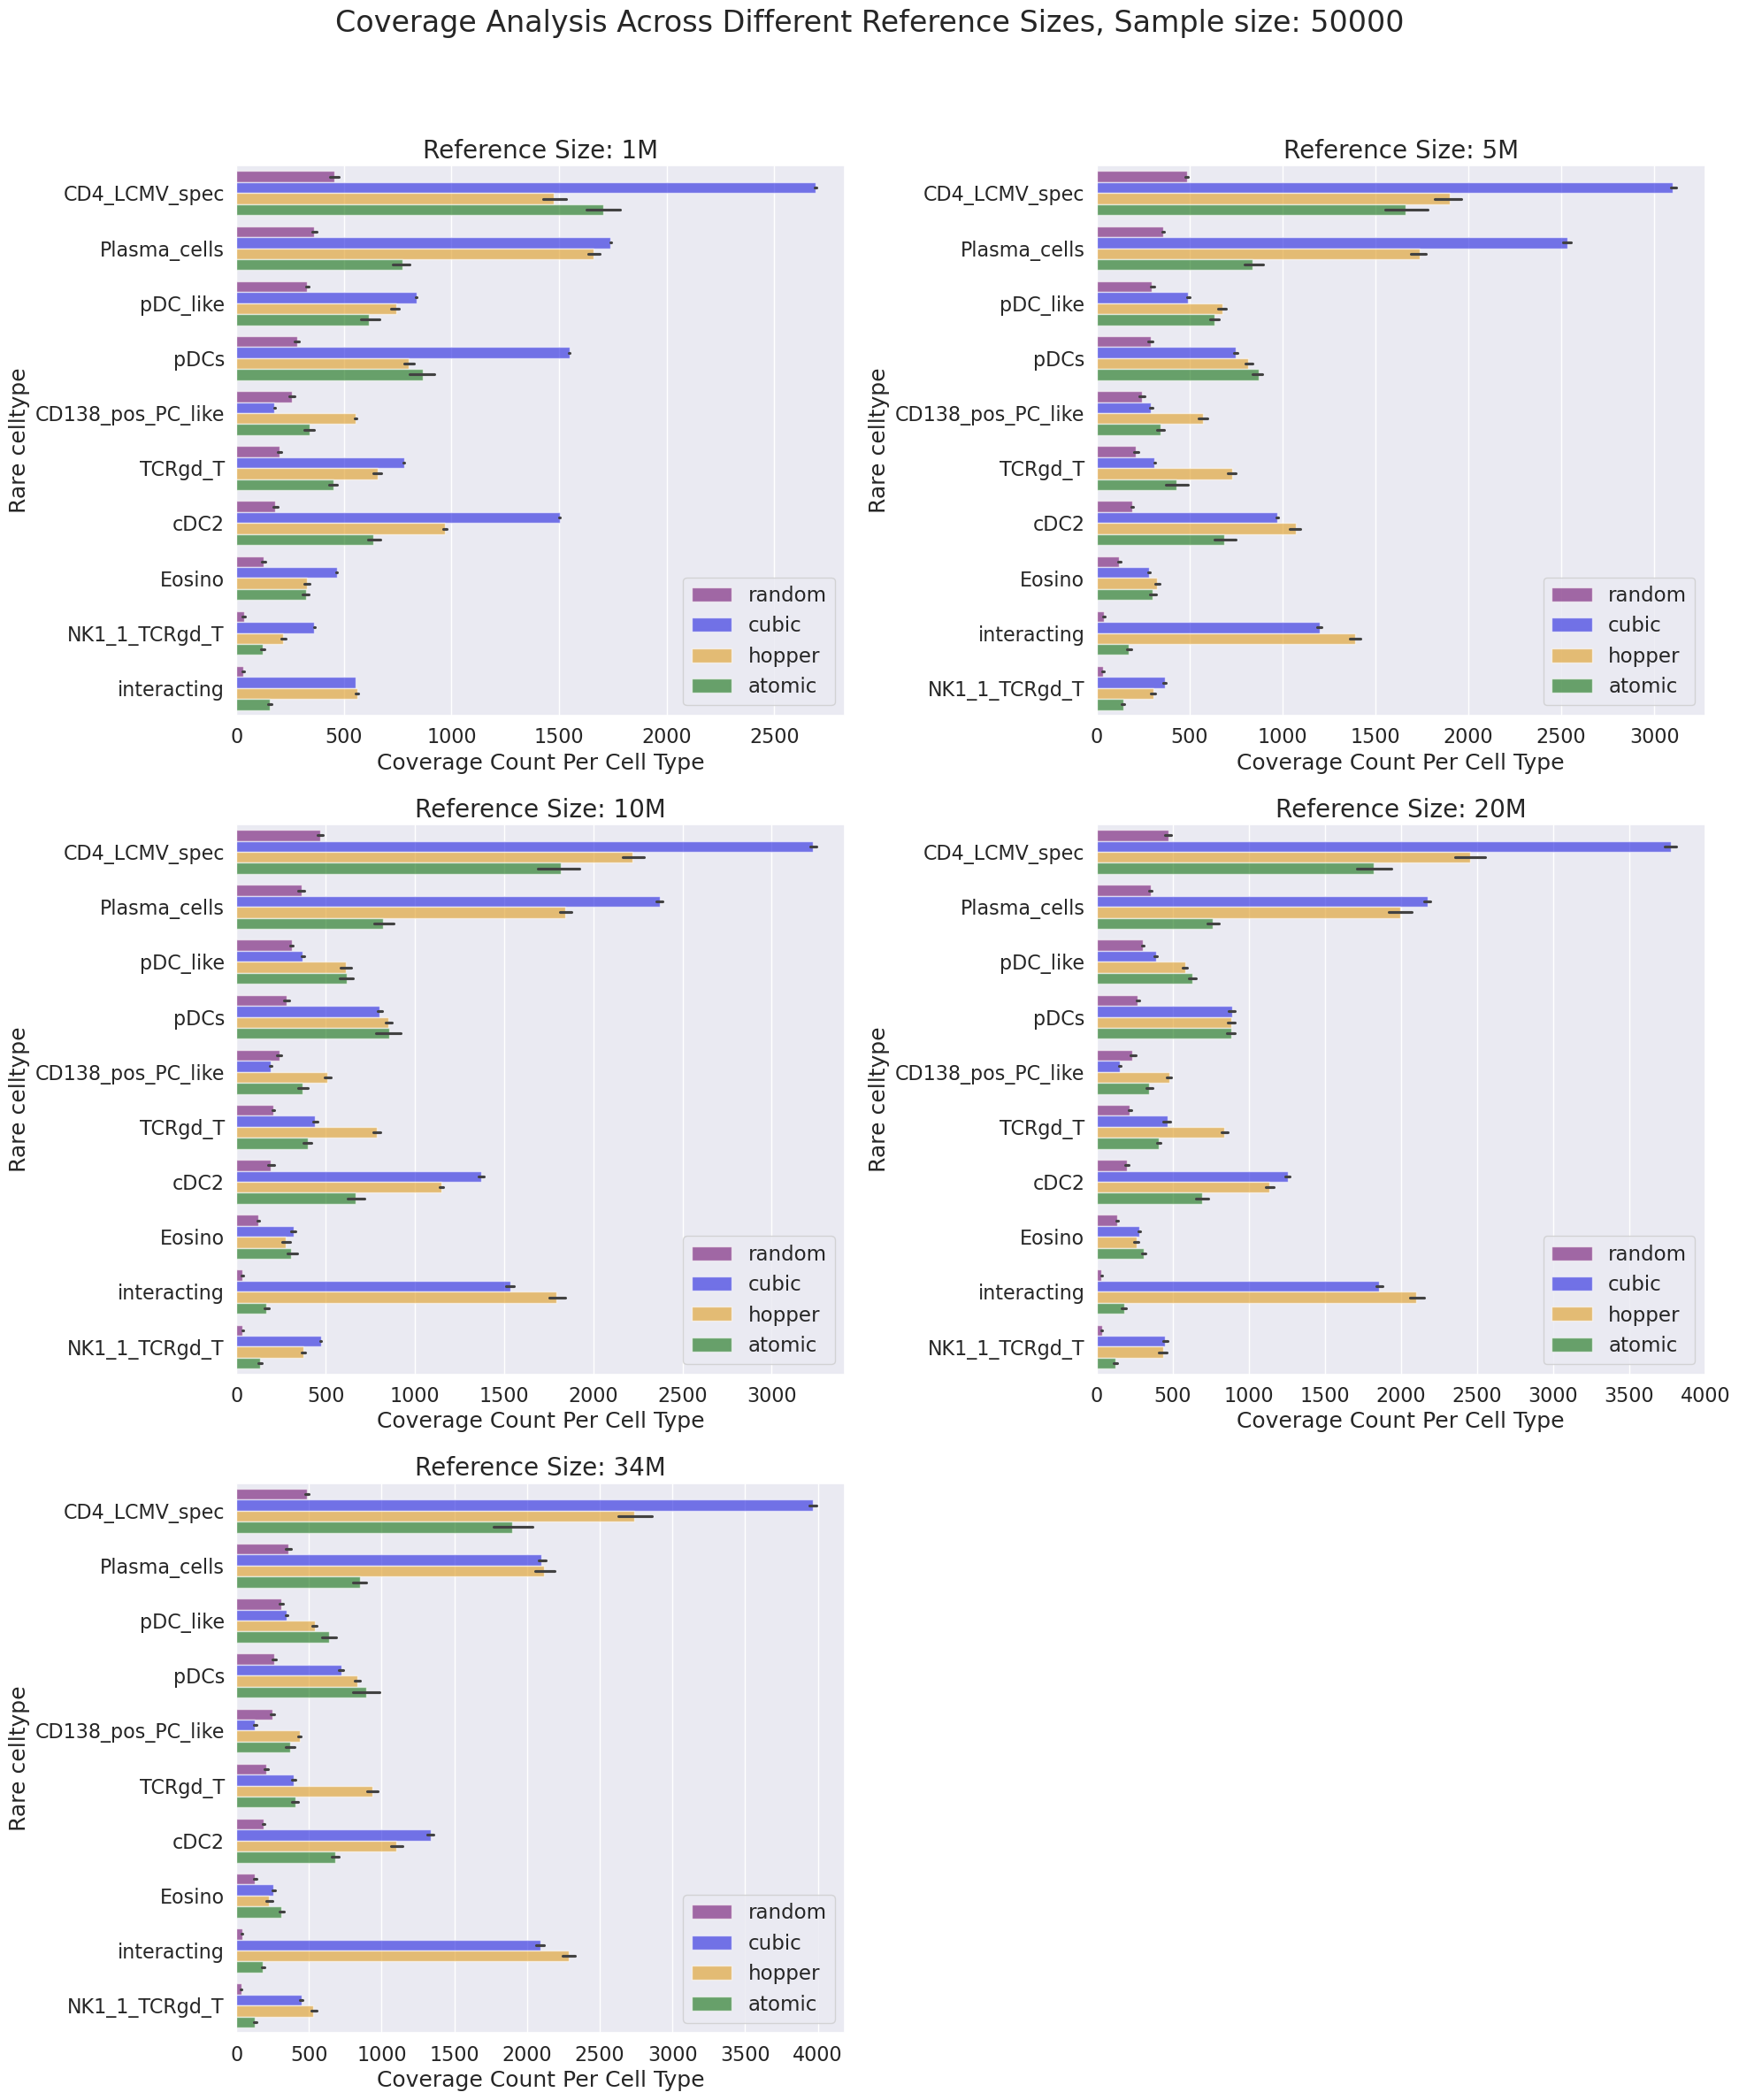

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings

# We'll ignore warnings to keep the notebook clean
warnings.filterwarnings('ignore')

# Assuming 'res' is a list of 7 DataFrames, one for each plot
# res = [df1, df2, ..., df7]
# Define your custom color palette for the different 'method' categories.
colors = ['purple', 'blue', 'orange', 'green']
# colors = ['purple', 'blue', 'orange']
# Assume 'label_key' is the column in your DataFrame that you want to display on the y-axis.
# Assume 'new_label_order' is the order in which you want to display the y-axis labels.

# Set font scale globally for larger fonts
sns.set(font_scale=1.5)

# Define the layout for your subplots
n_rows = 4  # Adjust the number of rows to fit 7 plots
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration and hide unused subplots
axes = axes.flatten()
for i in range(len(res), n_rows * n_cols):
    axes[i].set_visible(False)

# Iterate over your dataset container 'res' which has the datasets for each subplot
for i, ref in enumerate(res.keys()):
    ax = axes[i]  # Select the current subplot
    
    # Create the bar plot for the current subplot
    sns.barplot(
        data=res[ref],
        x="count",
        y=label_key,
        hue="method",
        palette=colors,
        order=new_label_orders[ref],
        alpha=.6,
        ax=ax  # Plot in the current subplot axis
    )

    # Customize the current subplot
    ax.set_title(f'Reference Size: {ref}M', size=20)
    ax.set_xlabel('Coverage Count Per Cell Type', size=18)
    ax.set_ylabel(f"Rare {label_key}", size=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()

fig.suptitle(f'Coverage Analysis Across Different Reference Sizes, Sample size: {size}', size=24, y=1.02)
# Adjust layout to prevent overlapping and show the plot
plt.tight_layout()
plt.savefig(f'figures/2_enhanced_rare_{label_key}_coverage_subplot_sample_size_{size}.png', dpi=300, bbox_inches='tight')
plt.show()


In [10]:
res[1][res[1][label_key] == 'CD138_pos_PC_like']

,celltype,count,method,coverage_percent
15,CD138_pos_PC_like,274,random,5.558937
41,CD138_pos_PC_like,177,cubic,3.590992
59,CD138_pos_PC_like,562,hopper,11.401907
80,CD138_pos_PC_like,332,atomic,6.735646
99,CD138_pos_PC_like,253,random,5.132887
125,CD138_pos_PC_like,179,cubic,3.631568
143,CD138_pos_PC_like,558,hopper,11.320755
164,CD138_pos_PC_like,370,atomic,7.506594
183,CD138_pos_PC_like,257,random,5.214039
209,CD138_pos_PC_like,179,cubic,3.631568


In [11]:
res[34][res[34][label_key] == 'CD138_pos_PC_like']

,celltype,count,method,coverage_percent
15,CD138_pos_PC_like,260,random,0.151565
41,CD138_pos_PC_like,121,cubic,0.070536
60,CD138_pos_PC_like,429,hopper,0.250082
79,CD138_pos_PC_like,419,atomic,0.244252
99,CD138_pos_PC_like,228,random,0.132911
125,CD138_pos_PC_like,138,cubic,0.080446
144,CD138_pos_PC_like,429,hopper,0.250082
163,CD138_pos_PC_like,376,atomic,0.219186
183,CD138_pos_PC_like,237,random,0.138157
209,CD138_pos_PC_like,129,cubic,0.075199


### size= 100000

In [12]:
size = 100000
res = res_size[size]
new_label_orders = new_lable_orders_size[size]

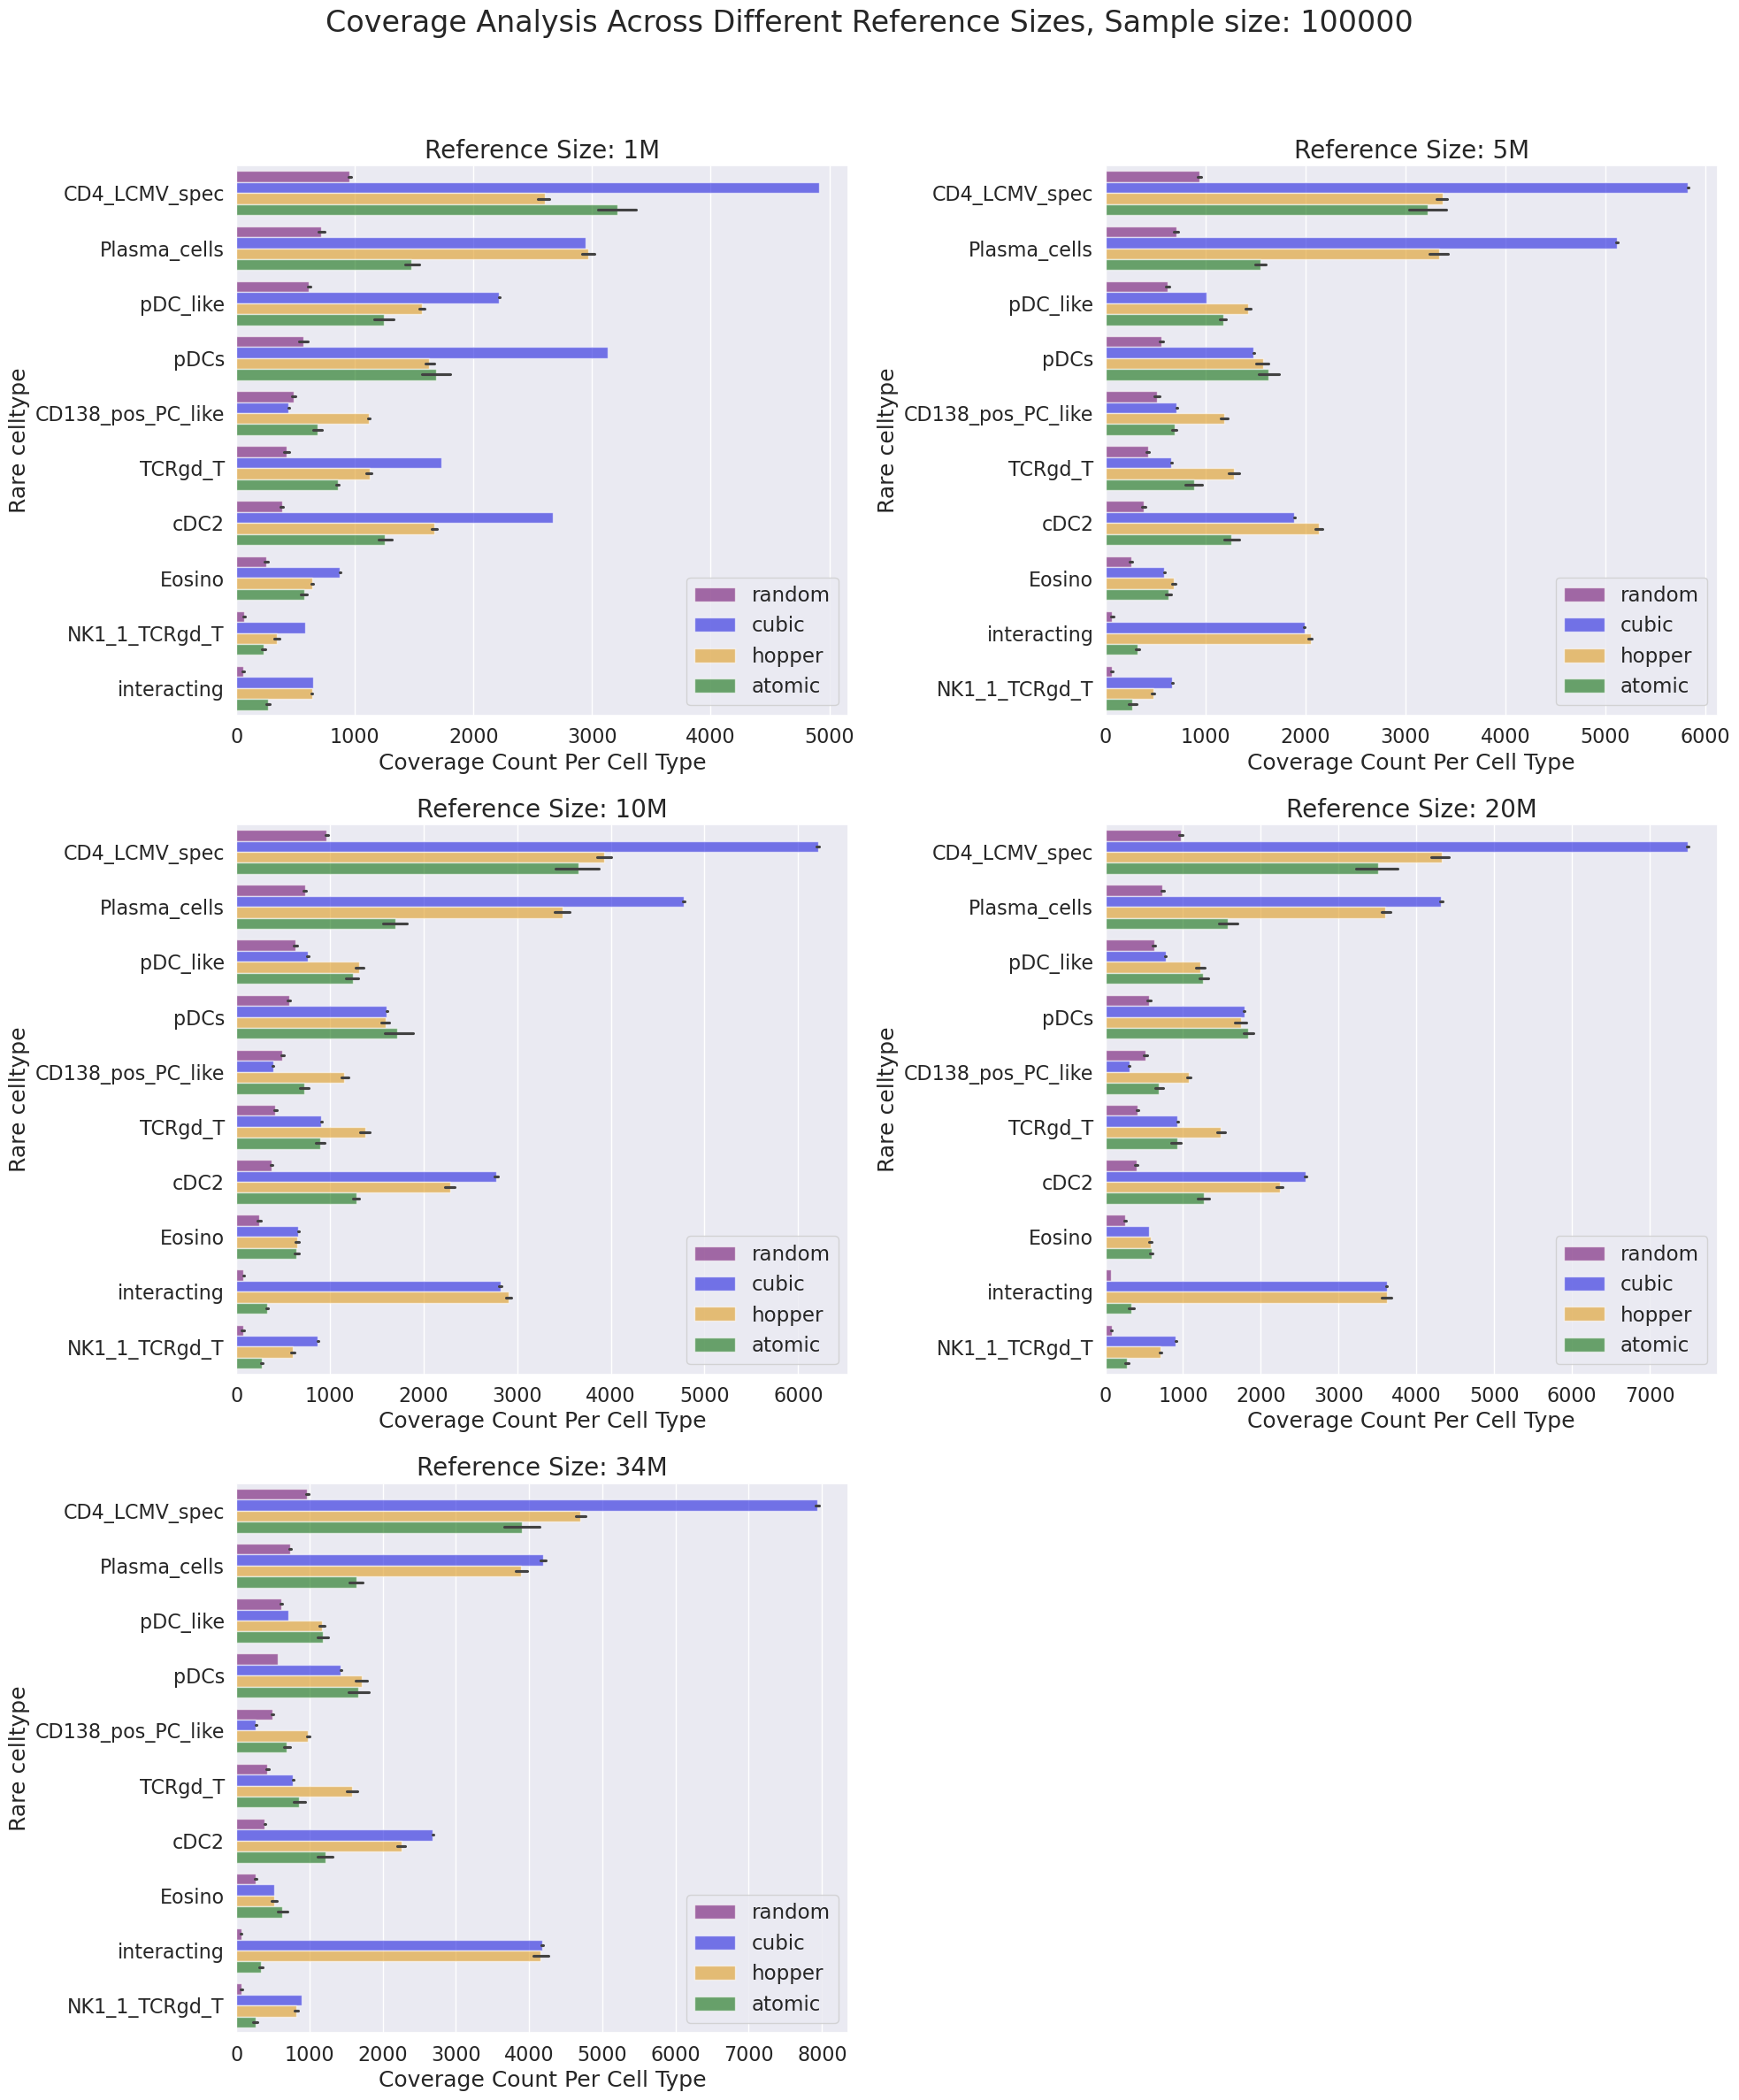

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings

# We'll ignore warnings to keep the notebook clean
warnings.filterwarnings('ignore')

# Assuming 'res' is a list of 7 DataFrames, one for each plot
# res = [df1, df2, ..., df7]
# Define your custom color palette for the different 'method' categories.
# colors = ['purple', 'blue', 'green', 'orange']
colors = ['purple', 'blue', 'orange', 'green']
# Assume 'label_key' is the column in your DataFrame that you want to display on the y-axis.
# Assume 'new_label_order' is the order in which you want to display the y-axis labels.

# Set font scale globally for larger fonts
sns.set(font_scale=1.5)

# Define the layout for your subplots
n_rows = 4  # Adjust the number of rows to fit 7 plots
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration and hide unused subplots
axes = axes.flatten()
for i in range(len(res), n_rows * n_cols):
    axes[i].set_visible(False)

# Iterate over your dataset container 'res' which has the datasets for each subplot
for i, ref in enumerate(res.keys()):
    ax = axes[i]  # Select the current subplot
    
    # Create the bar plot for the current subplot
    sns.barplot(
        data=res[ref],
        x="count",
        y=label_key,
        hue="method",
        palette=colors,
        order=new_label_orders[ref],
        alpha=.6,
        ax=ax  # Plot in the current subplot axis
    )

    # Customize the current subplot
    ax.set_title(f'Reference Size: {ref}M', size=20)
    ax.set_xlabel('Coverage Count Per Cell Type', size=18)
    ax.set_ylabel(f"Rare {label_key}", size=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()

fig.suptitle(f'Coverage Analysis Across Different Reference Sizes, Sample size: {size}', size=24, y=1.02)
# Adjust layout to prevent overlapping and show the plot
plt.tight_layout()
plt.savefig(f'figures/2_enhanced_rare_{label_key}_coverage_subplot_sample_size_{size}.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
res[1][res[1][label_key] == 'CD138_pos_PC_like']

,celltype,count,method,coverage_percent
15,CD138_pos_PC_like,487,random,9.880300
41,CD138_pos_PC_like,443,cubic,8.987624
59,CD138_pos_PC_like,1124,hopper,22.803814
80,CD138_pos_PC_like,747,atomic,15.155204
99,CD138_pos_PC_like,492,random,9.981741
125,CD138_pos_PC_like,442,cubic,8.967336
143,CD138_pos_PC_like,1124,hopper,22.803814
164,CD138_pos_PC_like,669,atomic,13.572733
183,CD138_pos_PC_like,457,random,9.271658
209,CD138_pos_PC_like,442,cubic,8.967336


In [15]:
res[5][res[5][label_key] == 'CD138_pos_PC_like']

,celltype,count,method,coverage_percent
15,CD138_pos_PC_like,494,random,1.982900
38,CD138_pos_PC_like,714,cubic,2.865974
59,CD138_pos_PC_like,1136,hopper,4.559868
80,CD138_pos_PC_like,652,atomic,2.617108
99,CD138_pos_PC_like,488,random,1.958817
122,CD138_pos_PC_like,712,cubic,2.857946
143,CD138_pos_PC_like,1249,hopper,5.013447
164,CD138_pos_PC_like,694,atomic,2.785694
182,CD138_pos_PC_like,563,random,2.259864
206,CD138_pos_PC_like,719,cubic,2.886043


In [16]:
res[34][res[34][label_key] == 'CD138_pos_PC_like']

,celltype,count,method,coverage_percent
15,CD138_pos_PC_like,509,random,0.296717
41,CD138_pos_PC_like,271,cubic,0.157977
59,CD138_pos_PC_like,967,hopper,0.563704
81,CD138_pos_PC_like,648,atomic,0.377746
99,CD138_pos_PC_like,488,random,0.284475
125,CD138_pos_PC_like,267,cubic,0.155645
143,CD138_pos_PC_like,986,hopper,0.574780
164,CD138_pos_PC_like,714,atomic,0.416220
183,CD138_pos_PC_like,505,random,0.294385
209,CD138_pos_PC_like,263,cubic,0.153313


### size=200000

In [17]:
size = 200000
res = res_size[size]
new_label_orders = new_lable_orders_size[size]

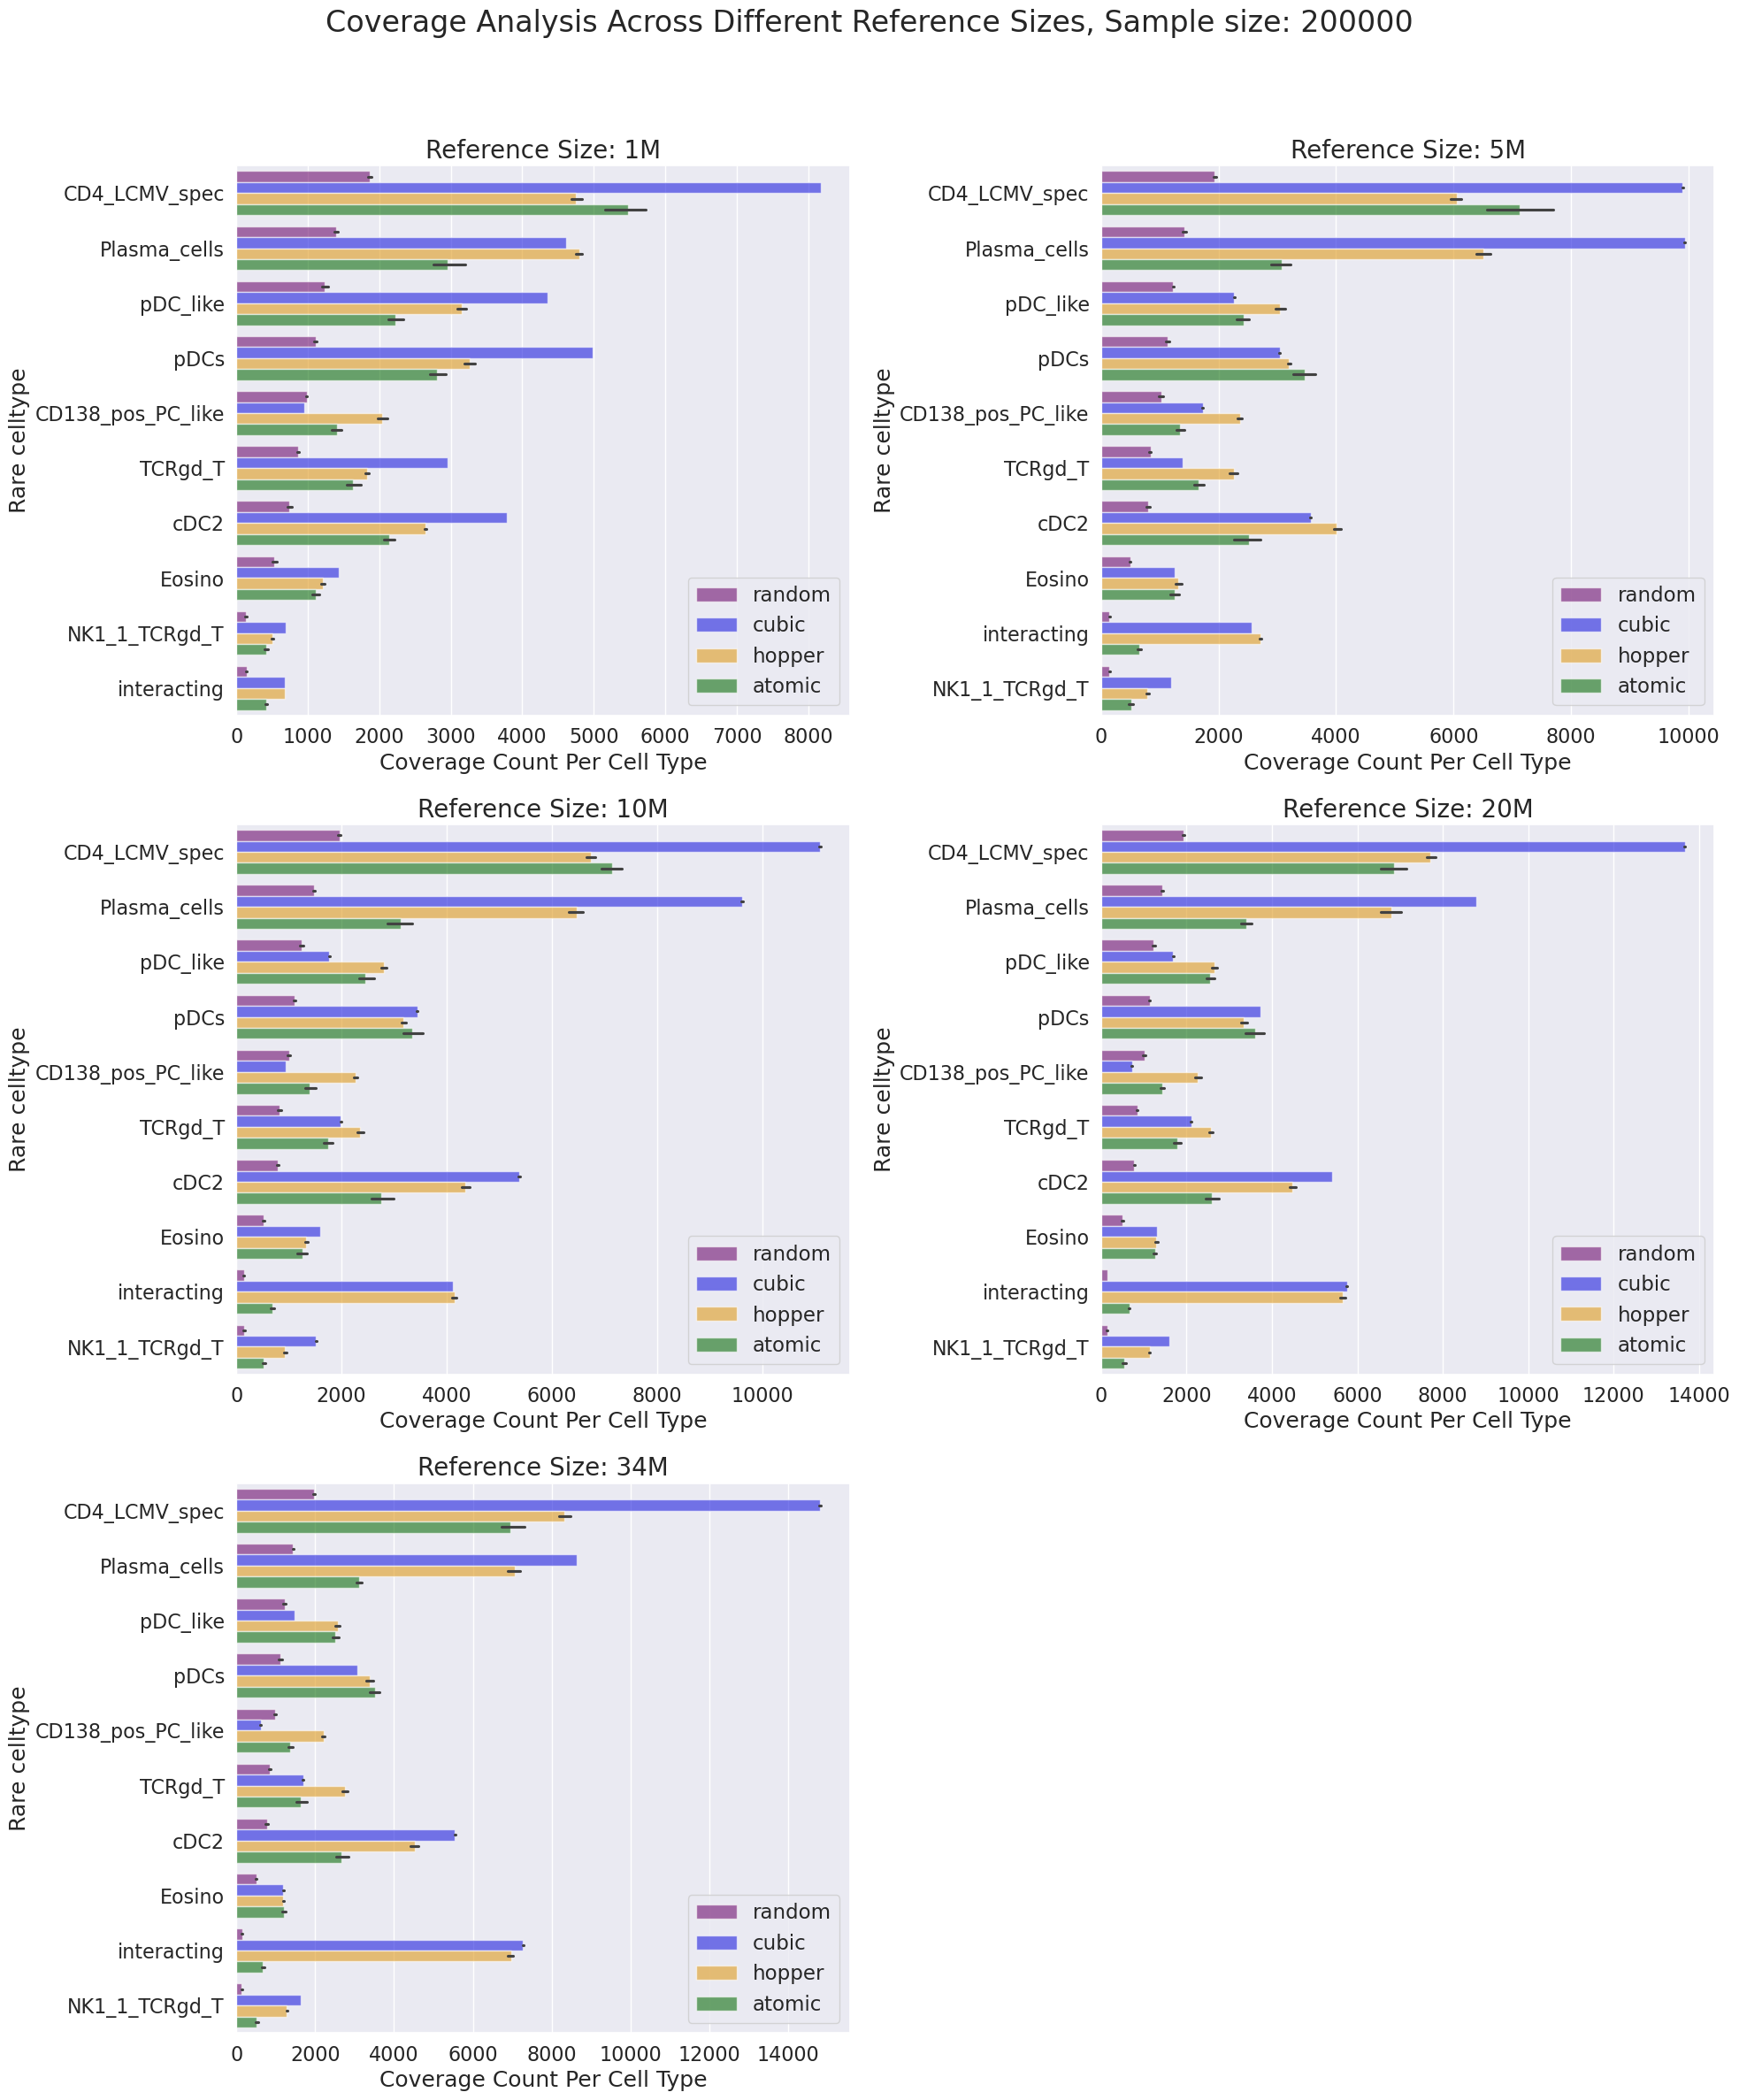

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings

# We'll ignore warnings to keep the notebook clean
warnings.filterwarnings('ignore')

# Assuming 'res' is a list of 7 DataFrames, one for each plot
# res = [df1, df2, ..., df7]
# Define your custom color palette for the different 'method' categories.
# colors = ['purple', 'blue', 'green', 'orange']
colors = ['purple', 'blue', 'orange', 'green']
# Assume 'label_key' is the column in your DataFrame that you want to display on the y-axis.
# Assume 'new_label_order' is the order in which you want to display the y-axis labels.

# Set font scale globally for larger fonts
sns.set(font_scale=1.5)

# Define the layout for your subplots
n_rows = 4  # Adjust the number of rows to fit 7 plots
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize as needed

# Flatten the axes array for easy iteration and hide unused subplots
axes = axes.flatten()
for i in range(len(res), n_rows * n_cols):
    axes[i].set_visible(False)

# Iterate over your dataset container 'res' which has the datasets for each subplot
for i, ref in enumerate(res.keys()):
    ax = axes[i]  # Select the current subplot
    
    # Create the bar plot for the current subplot
    sns.barplot(
        data=res[ref],
        x="count",
        y=label_key,
        hue="method",
        palette=colors,
        order=new_label_orders[ref],
        alpha=.6,
        ax=ax  # Plot in the current subplot axis
    )

    # Customize the current subplot
    ax.set_title(f'Reference Size: {ref}M', size=20)
    ax.set_xlabel('Coverage Count Per Cell Type', size=18)
    ax.set_ylabel(f"Rare {label_key}", size=18)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.legend()

fig.suptitle(f'Coverage Analysis Across Different Reference Sizes, Sample size: {size}', size=24, y=1.02)
# Adjust layout to prevent overlapping and show the plot
plt.tight_layout()
plt.savefig(f'figures/2_enhanced_rare_{label_key}_coverage_subplot_sample_size_{size}.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
res[1][res[1][label_key] == 'interacting']

,celltype,count,method,coverage_percent
20,interacting,123,random,17.903930
41,interacting,681,cubic,99.126638
61,interacting,677,hopper,98.544396
83,interacting,426,atomic,62.008734
103,interacting,160,random,23.289665
125,interacting,681,cubic,99.126638
145,interacting,678,hopper,98.689956
167,interacting,427,atomic,62.154294
187,interacting,144,random,20.960699
209,interacting,681,cubic,99.126638


In [20]:
res[34][res[34][label_key] == 'interacting']

,celltype,count,method,coverage_percent
20,interacting,128,random,0.509716
32,interacting,7270,cubic,28.950303
52,interacting,7026,hopper,27.978656
82,interacting,728,atomic,2.899012
103,interacting,151,random,0.601306
116,interacting,7256,cubic,28.894552
138,interacting,6808,hopper,27.110545
166,interacting,648,atomic,2.580440
188,interacting,128,random,0.509716
200,interacting,7284,cubic,29.006053
